In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
class NoisyMNIST(datasets.MNIST):
    def __init__(self, noise_factor=0.1, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root='./data', train=train, transform=transform,
                                           target_transform=target_transform, download=download)
        self.noise_factor = noise_factor

    def __getitem__(self, index):
        img, target = super(NoisyMNIST, self).__getitem__(index)
        # Create a noisy image by adding Gaussian noise
        noise = self.noise_factor * torch.randn(img.size())
        noisy_img = img + noise

        noisy_img = torch.clamp(noisy_img, 0., 1.)

        return noisy_img, img


In [5]:
# Define our transform ( Image to Tensor )
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
noise_factor = 0.3

mnist_train_dataset = NoisyMNIST(noise_factor=noise_factor, train=True, transform=transform, download=True)
mnist_test_dataset  = NoisyMNIST(noise_factor=noise_factor, train=False, transform=transform, download=True)

batch_size = 128

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.49MB/s]


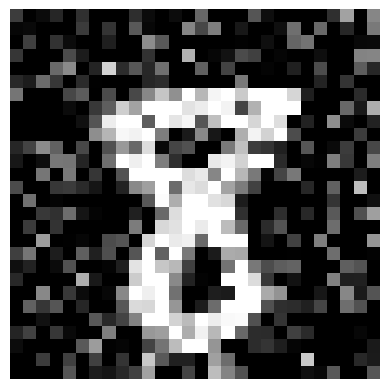

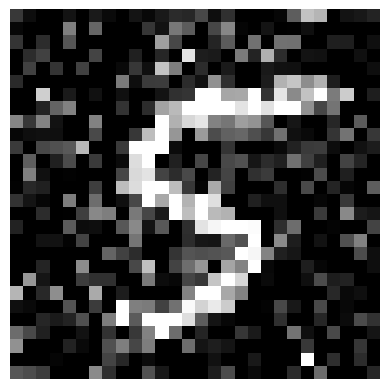

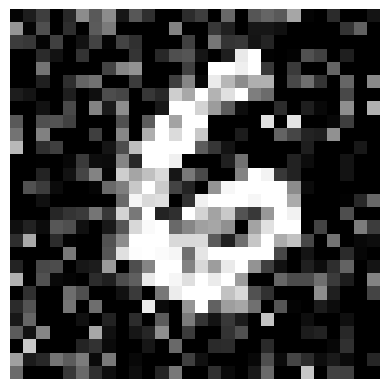

In [20]:
l = [noisy.to(device) for noisy,_ in mnist_test_loader]
noisy = [i.cpu().numpy() for i in l]
img = noisy[1][1].squeeze()
for i in range(3):
  plt.imshow(noisy[1][i].squeeze(), cmap="gray")
  plt.axis('off')
  plt.show()

In [7]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=1),  # (16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (16,14,14)
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                           # (32,7,7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), # (16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  # (1,28,28)
            nn.Sigmoid()
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
mnist_model = MNISTAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3)


In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    mnist_model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in mnist_train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = mnist_model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(mnist_train_loader):.4f}")


Epoch [1/10], Loss: 0.0363
Epoch [2/10], Loss: 0.0107
Epoch [3/10], Loss: 0.0092
Epoch [4/10], Loss: 0.0086
Epoch [5/10], Loss: 0.0082
Epoch [6/10], Loss: 0.0080
Epoch [7/10], Loss: 0.0078
Epoch [8/10], Loss: 0.0076
Epoch [9/10], Loss: 0.0075
Epoch [10/10], Loss: 0.0074


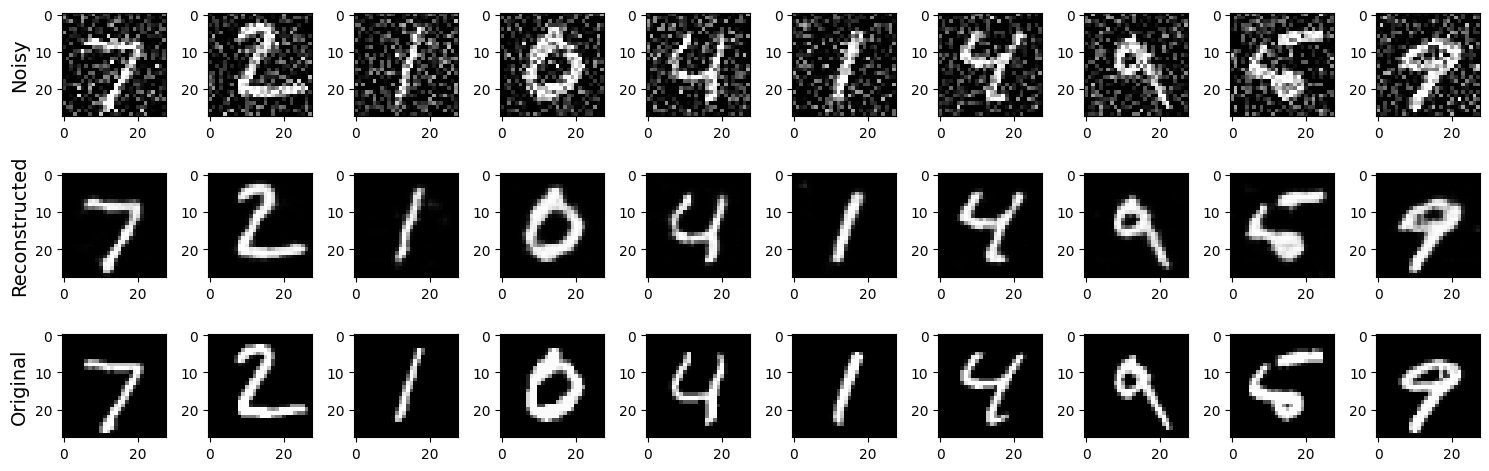

In [10]:
def show_images(noisy, output, original):
    noisy = noisy.cpu().numpy()
    output = output.cpu().detach().numpy()
    original = original.cpu().numpy()

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))

    # Row titles
    row_titles = ['Noisy', 'Reconstructed', 'Original']

    for row_idx, images in enumerate([noisy, output, original]):
        for col_idx in range(10):
            axes[row_idx][col_idx].imshow(images[col_idx].squeeze(), cmap='gray')

        axes[row_idx][0].set_ylabel(row_titles[row_idx], fontsize=14)

    plt.tight_layout()
    plt.show()


mnist_model.eval()
with torch.no_grad():
    for noisy_imgs, clean_imgs in mnist_test_loader:
        noisy_imgs = noisy_imgs.to(device)
        outputs = mnist_model(noisy_imgs)
        show_images(noisy_imgs, outputs, clean_imgs)
        break


In [11]:
#Let's define a custom dataset wrapper for CIFAR-10 that adds noise
class NoisyCIFAR10(datasets.CIFAR10):
    def __init__(self, noise_factor=0.1, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root='./data', train=train, transform=transform,
                                           target_transform=target_transform, download=download)
        self.noise_factor = noise_factor

    def __getitem__(self, index):
        # Get the clean image and label from CIFAR-10
        img, target = super(NoisyCIFAR10, self).__getitem__(index)
        # Create a noisy image by adding Gaussian noise
        noise = self.noise_factor * torch.randn(img.size())
        noisy_img = img + noise
        # Clamp the values to [0, 1]
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        # Return noisy image as input and clean image as target
        return noisy_img, img

In [12]:
#Setting up my noise_factor and loading the training/testing data using CIFAR-10's Default split
#train=True loads 50k images as training data, and train=False loads 10k imaegs as testing data
noise_factor = 0.1
cifar_train_dataset = NoisyCIFAR10(noise_factor=noise_factor, train=True, transform=transform, download=True)
cifar_test_dataset  = NoisyCIFAR10(noise_factor=noise_factor, train=False, transform=transform, download=True)

batch_size = 128
cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
cifar_test_loader  = DataLoader(cifar_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


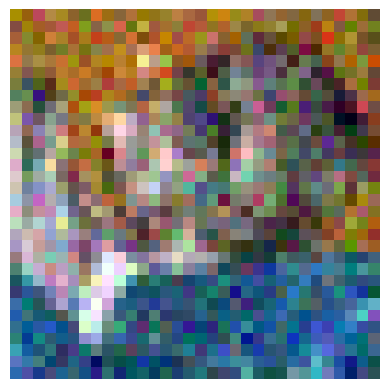

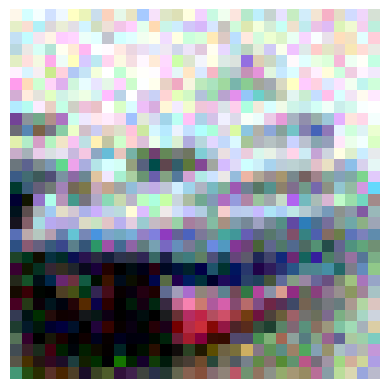

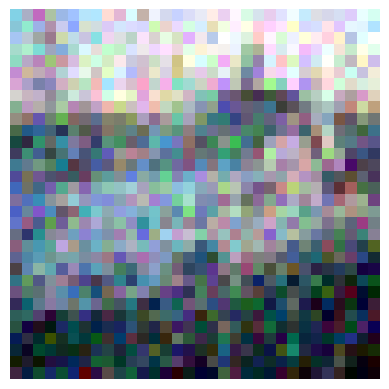

In [18]:
l_cifar = [noisy.to(device) for noisy,_ in cifar_test_loader]
noisy_cifar = [i.cpu().numpy() for i in l_cifar]
for i in range(3):
  plt.imshow(np.transpose(noisy_cifar[0][i].squeeze(), (1, 2, 0)))
  plt.imshow(np.transpose(noisy_cifar[0][i].squeeze(), (1, 2, 0)))
  plt.axis('off')
  plt.show()


In [14]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder: Convolution layers with BatchNorm
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.pool = nn.MaxPool2d(2, 2)  # reduces spatial dimensions by half

        # Bottom (bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Decoder: using transposed convolutions with skip connections
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # (64, 32, 32)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),  # I'll be combining skip connection (enc2 + up1, hence the 64+64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)         # (32,32,32)
        enc2 = self.enc_conv2(enc1)        # (64,32,32)
        pooled = self.pool(enc2)           # (64,16,16)
        # Bottleneck
        bottleneck = self.bottleneck(pooled)  # (128,16,16)

        # Decoder
        up1 = self.up1(bottleneck)  # (64,32,32)
        # Skip connection: concatenate with enc2
        dec1 = torch.cat([up1, enc2], dim=1)  # (64+64,32,32) = (128,32,32)
        dec1 = self.dec_conv1(dec1)           # (64,32,32)

        output = self.final(dec1)  # (3,32,32)
        return output

In [15]:
# Instantiate the model, loss function and optimizer
cifar_model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss between clean and reconstructed image
optimizer = optim.Adam(cifar_model.parameters(), lr=1e-3)

In [16]:
# Training loop
num_epochs = 30
print("Starting training...")
for epoch in range(num_epochs):
    cifar_model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in cifar_train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = cifar_model(noisy_imgs)

        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_imgs.size(0)

    epoch_loss = running_loss / len(cifar_train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training completed.")

Starting training...
Epoch [1/30], Loss: 0.0029
Epoch [2/30], Loss: 0.0021
Epoch [3/30], Loss: 0.0020
Epoch [4/30], Loss: 0.0019
Epoch [5/30], Loss: 0.0018
Epoch [6/30], Loss: 0.0018
Epoch [7/30], Loss: 0.0018
Epoch [8/30], Loss: 0.0018
Epoch [9/30], Loss: 0.0017
Epoch [10/30], Loss: 0.0017
Epoch [11/30], Loss: 0.0017
Epoch [12/30], Loss: 0.0017
Epoch [13/30], Loss: 0.0017
Epoch [14/30], Loss: 0.0016
Epoch [15/30], Loss: 0.0016
Epoch [16/30], Loss: 0.0016
Epoch [17/30], Loss: 0.0016
Epoch [18/30], Loss: 0.0016
Epoch [19/30], Loss: 0.0016
Epoch [20/30], Loss: 0.0016
Epoch [21/30], Loss: 0.0016
Epoch [22/30], Loss: 0.0015
Epoch [23/30], Loss: 0.0015
Epoch [24/30], Loss: 0.0015
Epoch [25/30], Loss: 0.0015
Epoch [26/30], Loss: 0.0015
Epoch [27/30], Loss: 0.0015
Epoch [28/30], Loss: 0.0015
Epoch [29/30], Loss: 0.0015
Epoch [30/30], Loss: 0.0015
Training completed.


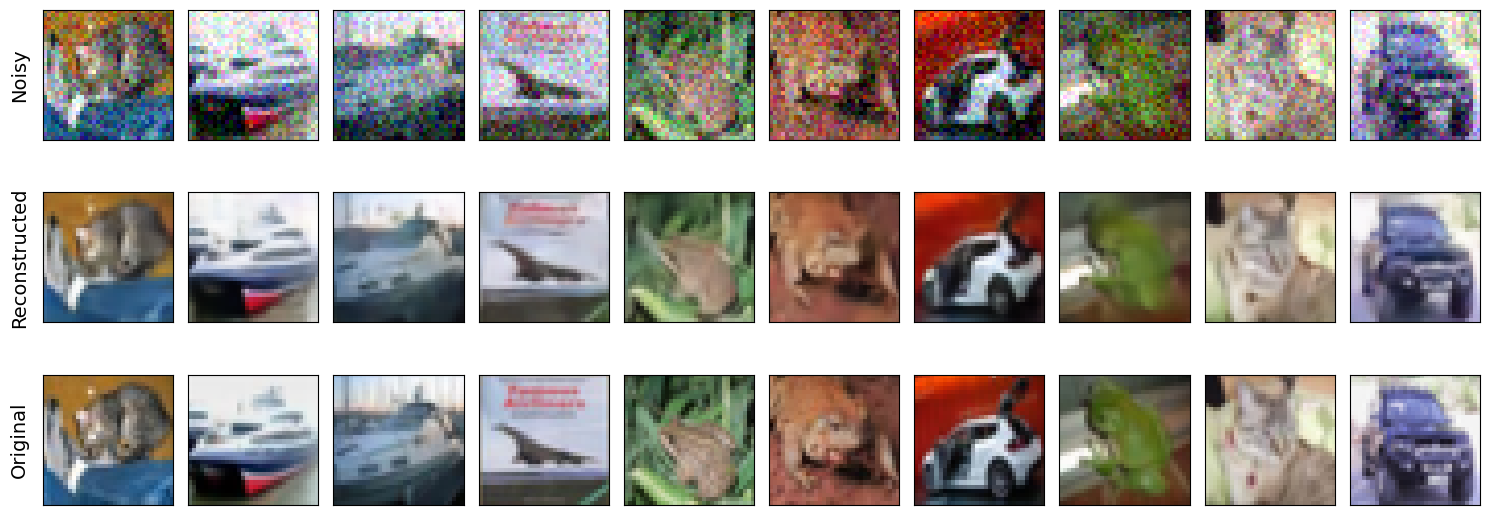

In [17]:
# Evaluate and visualize some denoising results from the test set
cifar_model.eval() # model in evalutation mode
dataiter = iter(cifar_test_loader)
noisy_imgs, original_imgs = next(dataiter)  # loading both noisy and original images
noisy_imgs = noisy_imgs.to(device)
with torch.no_grad():
    outputs = cifar_model(noisy_imgs)

# Convert tensors to numpy arrays for plotting (move to CPU and detach)
noisy_imgs = noisy_imgs.cpu().numpy()
outputs = outputs.cpu().numpy()
original_imgs = original_imgs.cpu().numpy()

# Plot noisy, denoised, and original images for a few examples
n = 10
fig, axes = plt.subplots(3, n, figsize=(15, 6))
row_titles = ['Noisy', 'Reconstructed', 'Original']

for row in range(3):
    for i in range(n):
        if row == 0:
            axes[row, i].imshow(np.transpose(noisy_imgs[i], (1, 2, 0)))
        elif row == 1:
            axes[row, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
        elif row == 2:
            axes[row, i].imshow(np.transpose(original_imgs[i], (1, 2, 0)))
        axes[row, i].set_xticks([])
        axes[row, i].set_yticks([])

# Set a vertical label for each row on the left-most subplot
axes[0, 0].set_ylabel(row_titles[0], fontsize=14, rotation=90, labelpad=10)
axes[1, 0].set_ylabel(row_titles[1], fontsize=14, rotation=90, labelpad=10)
axes[2, 0].set_ylabel(row_titles[2], fontsize=14, rotation=90, labelpad=10)

plt.tight_layout()
plt.show()